In [191]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from keras import backend as K
from tensorflow import keras
import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio

from IPython import display

import pickle

np.set_printoptions(precision=3, suppress=True)

In [50]:
COLUMN_NAMES = ["dim1", "dim2", "dim3", "dim4", 
                "dim5", "dim6", "dim7", "dim8", 
                "dim9", "dim10", "label"]
LABEL_NAME = "label"
INPUT_NAMES = list(COLUMN_NAMES)
INPUT_NAMES.remove(LABEL_NAME)
trajectory_list = pickle.load(open("N-Dim_Doublewell/trajectory_list.p", "rb"))
trajectory_label_list = pickle.load(open("N-Dim_Doublewell/trajectory_label_list.p", "rb"))
BATCH_SIZE = 64
#SHUFFLE_BUFFER_SIZE = 1000000
CORES_USED = 3

# sets a random seed for reproducibility of the shuffling process
SEED = 5



In [51]:
# additional section can be used for generation of present/future pairs

OFFSET = 5
def generate_offset_snapshot_list(trajectory_list, offset):
    # Takes in a list or np.array of trajectories and an offset value and generates two np.arrays with respective new versions
    # of the trajectories. 
    # present_trajectory_list contains all snapshots of the trajectories excluding
    # the last n (speficified by offset) of each.
    # future_trajectory_list contains all snapshots of the trajectories excluding
    # the first n (specified by offset) of each.
    # Consequently the both lists can be used as input and desired output of an autoencoder to
    # train for future predictive variables.
    present_trajectory_list = np.array([trajectory[:-offset] for trajectory in trajectory_list])  
    #truncated_present_trajectory_list = 
    future_trajectory_list = np.array([trajectory[offset:] for trajectory in trajectory_list])
    return present_trajectory_list, future_trajectory_list

def get_snapshot_and_label_list(trajectory_list, trajectory_label_list, offset = 0, future = False):
    # takes in a list of trajectories and corresponding labels and generates concatenated lists of snapshots, 
    # snapshot label and snapshot progress labels
    # can be used for present/future trajcetory lists by use or offset (same as used for generation of the list)
    # and future = True for the future trajectory list
    snapshot_list = []
    snapshot_label_list = []
    snapshot_progress_label_list = []
    for trajectory_nr in range(len(trajectory_list)):
        trajectory = trajectory_list[trajectory_nr]
        trajectory_label = trajectory_label_list[trajectory_nr]
        for snapshot_nr in range(len(trajectory)):
            snapshot_list.append(trajectory[snapshot_nr])
            snapshot_label_list.append(trajectory_label)
            # Calculates the progress along the path for AB paths. If the path label is 1 or 0,
            # all snapshot are assigned the same label. If the path label is different (e.g. 0.5),
            # indicating a sucessfull transition a progress along the snapshots is calculated based on
            # the position within the trajectory and the total trajectory length.
            # For present/future lists, the offset needs to be taken into account in the denominator
            # If the dataset is a future variant of an offset trajectory list the progress label 
            # needs to additionally take the offset into account in the nominator.
            if trajectory_label == 0.0 or trajectory_label == 1.0:
                snapshot_progress_label_list.append(trajectory_label)
            else:
                if future == True:
                    snapshot_progress_label_list.append((snapshot_nr + offset)/(len(trajectory) - 1.0 + offset))
                else:
                    snapshot_progress_label_list.append(snapshot_nr/(len(trajectory)-1.0 + offset))
    return np.array(snapshot_list), np.array(snapshot_label_list), np.array(snapshot_progress_label_list)



In [52]:
snapshot_list, snapshot_label_list, snapshot_progress_label_list = get_snapshot_and_label_list(trajectory_list, trajectory_label_list)

#present_trajectory_list, future_trajectory_list = generate_offset_snapshot_list(trajectory_list, OFFSET)

#present_snapshot_list, present_snapshot_label_list, present_snapshot_progress_label_list = get_snapshot_and_label_list(
#    present_trajectory_list, trajectory_label_list, OFFSET)
#future_snapshot_list, future_snapshot_label_list, future_snapshot_progress_label_list = get_snapshot_and_label_list(
#    future_trajectory_list, trajectory_label_list, OFFSET, future = True)

# Sets a split size for train and test data set
DATASET_SIZE = len(snapshot_label_list)
TRAIN_SIZE = int(DATASET_SIZE * 0.7)

In [53]:

# generates the dataset by feeding in a tuple, of dictionaries (alternative would be a tuble of lists)
ds = tf.data.Dataset.from_tensor_slices(({"input_snapshots": snapshot_list},
                                        {"label":snapshot_label_list, 
                                         "reconstruction":snapshot_list})).shuffle(DATASET_SIZE)
train_ds = ds.take(TRAIN_SIZE).batch(BATCH_SIZE)
test_ds = ds.skip(TRAIN_SIZE).batch(BATCH_SIZE)

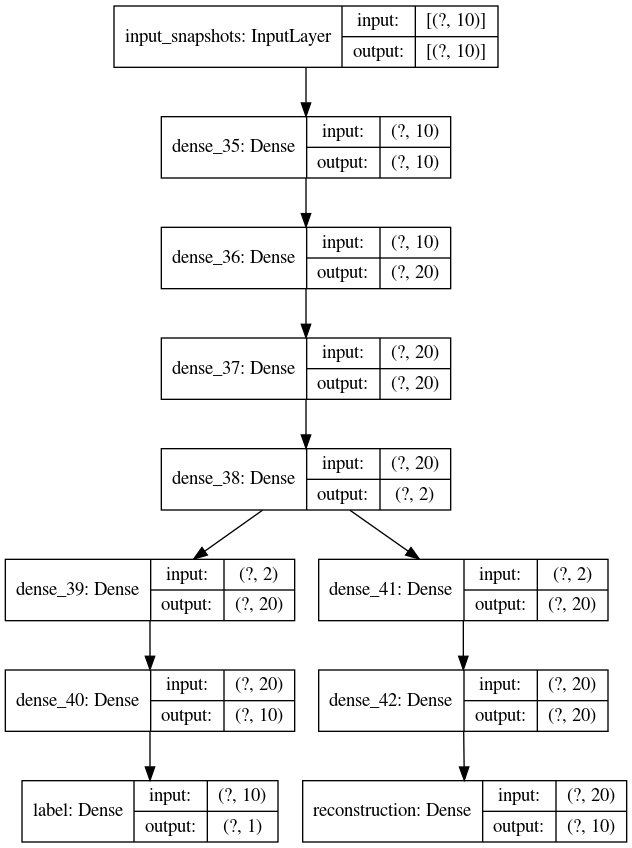

In [164]:
import pydot
%matplotlib notebook
input_snapshots = keras.Input(shape=(len(INPUT_NAMES),),name="input_snapshots")
x = keras.layers.Dense(len(INPUT_NAMES), activation= 'tanh')(input_snapshots)
x = keras.layers.Dense(len(INPUT_NAMES)*2, activation='tanh')(x)
x = keras.layers.Dense(len(INPUT_NAMES)*2, activation='tanh')(x)
x = keras.layers.Dense(2, activation='tanh')(x)

x1 = keras.layers.Dense(len(INPUT_NAMES)*2, activation='tanh')(x)
x1 = keras.layers.Dense(len(INPUT_NAMES), activation='tanh')(x1)
output_1 = keras.layers.Dense(1, activation='tanh',name="label")(x1)

x2 = keras.layers.Dense(len(INPUT_NAMES)*2, activation='tanh')(x)
x2 = keras.layers.Dense(len(INPUT_NAMES)*2, activation='tanh')(x2)
output_2 = keras.layers.Dense(len(INPUT_NAMES), activation='tanh',name="reconstruction")(x2)



model = keras.Model(inputs=input_snapshots,outputs=[output_1,output_2])
model_layout = keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)
display.display(model_layout)


In [165]:
model.compile(optimizer=keras.optimizers.RMSprop(1e-3),
              loss={'label':keras.losses.MeanAbsoluteError(),
                      'reconstruction': keras.losses.MeanAbsoluteError()},
              loss_weights=[1., 0.2])

In [166]:
model.fit(train_ds,
          epochs=10)


Train for 2522 steps
Epoch 1/10
2522/2522 [==============================] - 5s 2ms/step - loss: 0.1385 - label_loss: 0.0577 - reconstruction_loss: 0.4043
Epoch 2/10
2522/2522 [==============================] - 4s 2ms/step - loss: 0.1189 - label_loss: 0.0408 - reconstruction_loss: 0.3906
Epoch 3/10
2522/2522 [==============================] - 5s 2ms/step - loss: 0.1178 - label_loss: 0.0399 - reconstruction_loss: 0.3896
Epoch 4/10
2522/2522 [==============================] - 5s 2ms/step - loss: 0.1170 - label_loss: 0.0391 - reconstruction_loss: 0.3894
Epoch 5/10
2522/2522 [==============================] - 5s 2ms/step - loss: 0.1160 - label_loss: 0.0382 - reconstruction_loss: 0.3890
Epoch 6/10
2522/2522 [==============================] - 5s 2ms/step - loss: 0.1153 - label_loss: 0.0375 - reconstruction_loss: 0.3889
Epoch 7/10
2522/2522 [==============================] - 5s 2ms/step - loss: 0.1152 - label_loss: 0.0375 - reconstruction_loss: 0.3887
Epoch 8/10
2522/2522 [===================

In [167]:
model.evaluate(test_ds, verbose=1, steps = 1000)

1000/1000 [==============================] - 2s 2ms/step - loss: 0.1107 - label_loss: 0.0332 - reconstruction_loss: 0.3873


[0.1106823996976018, 0.03321529, 0.38733545]

In [241]:
#print(model.predict([[0, -1] + [0 for i in range(8)]]))
#print(model.predict(snapshot_list[:1000])[1][0][1])
def map_generated_labels(model, x_list, y_list, additional_dim_nr, additional_dim_val):
    label_map = []
    for x in x_list:
        label_current_row = []
        for y in y_list:
            label_current_row.append(model.predict([[x, y] + [additional_dim_val for i in range(additional_dim_nr)]])[0][0][0])
        label_map.append(label_current_row)
        #print(label_current_row)
    return np.array(label_map)
label_map_generated = map_generated_labels(model, np.linspace(-1,1,21), np.linspace(-1,1,21), 8, 0)


In [253]:
import math
def map_given_labels(snapshot_list, snapshot_label_list, x_list, y_list):
    x_nr = len(x_list)
    y_nr = len(y_list)
    # determines the lenght of half a step on the grid to see which grid point the snapshot belongs to
    x_half_step = (max(x_list) - min(x_list)) / (2 * float(x_nr-1))
    y_half_step = (max(y_list) - min(y_list)) / (2 * float(y_nr-1))
    label_map = []
    for x in x_list:
        label_current_row = []
        for y in y_list:
            label_current_entry = []
            for snapshot_nr in range(len(snapshot_list)):
                x_snap, y_snap = snapshot_list[snapshot_nr][:2]
                # check whether current snapshot is close to current x and y, if it is, add label to current entry
                if abs(x_snap - x) <= x_half_step and abs(y_snap - y) <= y_half_step:
                    label_current_entry.append(snapshot_label_list[snapshot_nr])
            # after all snapshots are done for this position, take the mean of the current entry
            # and append it to current row
            if len(label_current_entry) > 0:
                label_current_row.append(np.mean(label_current_entry))
            else:
                label_current_row.append(float('NaN'))
        label_map.append(label_current_row)
    return label_map
label_map_given = map_given_labels(snapshot_list, snapshot_label_list, np.linspace(-1,1,21), np.linspace(-1,1,21))

<IPython.core.display.Javascript object>


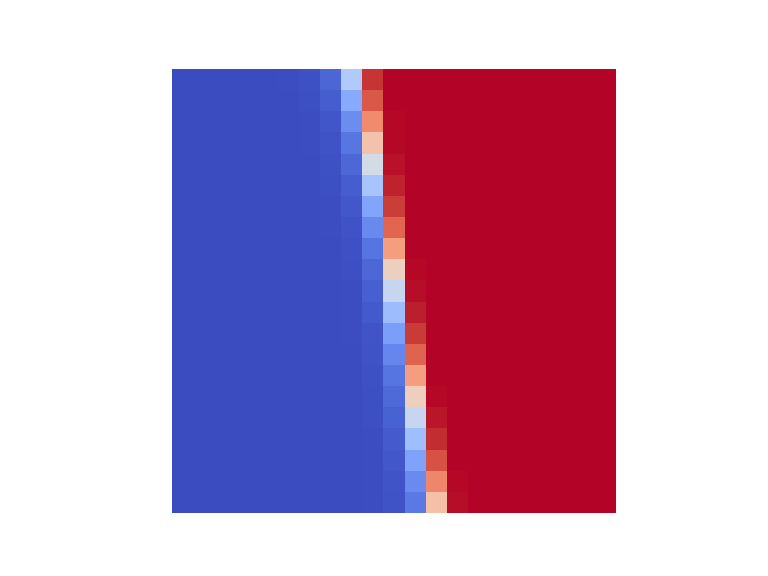

In [284]:
plt.close()
# use [::-1] to invert the new y_axis
plt.imshow(np.transpose(label_map_generated)[::-1], cmap='coolwarm', interpolation='nearest')
plt.axis('off')
plt.savefig("label_map_generated.png")
plt.show()


<IPython.core.display.Javascript object>


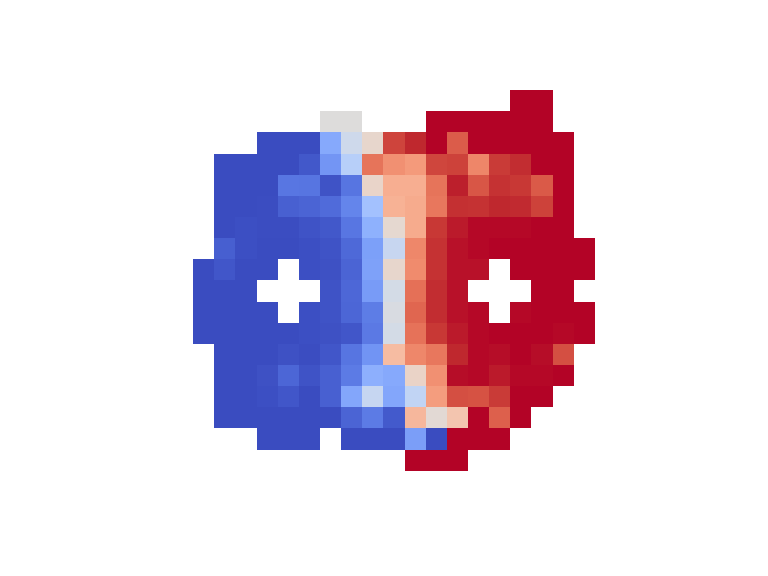

In [290]:
plt.close()
plt.imshow(np.transpose(label_map_given)[::-1], cmap='coolwarm', interpolation='nearest')
plt.axis('off')
plt.savefig("label_map_given.png")
plt.show()

In [123]:
took1 = train_s_ds.take(1)
for element in took1.as_numpy_iterator():
    print(element)
took1 = train_sl_ds.take(1)
for element in took1.as_numpy_iterator():
    print(element)
took1 = train_spl_ds.take(1)
for element in took1.as_numpy_iterator():
    print(element)

NameError: name 'train_s_ds' is not defined

In [40]:
# accessing the output of all layers

features_list = [layer.output for layer in model.layers]
print(features_list)
feat_extraction_model = keras.Model(inputs=model.input, outputs=features_list)

img = np.random.random((1,10)).astype('float32')
extracted_features = feat_extraction_model(img)
print(extracted_features)

[<tf.Tensor 'input_snapshots_19:0' shape=(None, 10) dtype=float32>, <tf.Tensor 'dense_11/Identity:0' shape=(None, 10) dtype=float32>, <tf.Tensor 'dense_12/Identity:0' shape=(None, 20) dtype=float32>, <tf.Tensor 'dense_13/Identity:0' shape=(None, 20) dtype=float32>, <tf.Tensor 'dense_14/Identity:0' shape=(None, 2) dtype=float32>, <tf.Tensor 'dense_15/Identity:0' shape=(None, 20) dtype=float32>, <tf.Tensor 'dense_17/Identity:0' shape=(None, 20) dtype=float32>, <tf.Tensor 'dense_16/Identity:0' shape=(None, 20) dtype=float32>, <tf.Tensor 'dense_18/Identity:0' shape=(None, 20) dtype=float32>, <tf.Tensor 'label_1/Identity:0' shape=(None, 1) dtype=float32>, <tf.Tensor 'reconstruction_1/Identity:0' shape=(None, 10) dtype=float32>]
[<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.578, 0.725, 0.533, 0.842, 0.729, 0.808, 0.3  , 0.716, 0.22 ,
        0.205]], dtype=float32)>, <tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[ 0.485,  0.301,  0.435,  0.394,  0.249, -0.656,  0.257,

In [130]:
example_batch, label_batch = next(iter(train_sl_ds))    


# with a Sequential model
output = K.function([model.layers[0].input],
                    [model.layers[3].output])
layer_output = output(example_batch)[0]
'''''''''''''''''''''''''''''''Do Stuff'
#print(output)
print(example_batch[0][:2])
print(layer_output[0])
print(label_batch[0])

tf.Tensor([0.673 0.176], shape=(2,), dtype=float64)
[-0.088  0.085]
tf.Tensor(1.0, shape=(), dtype=float64)


200/200 [==============================] - 0s 1ms/step - loss: 0.2169 - mean_squared_error: 0.2169


In [ ]:
encoder_input = keras.Input(shape=(28, 28, 1), name='img')
x = layers.Conv2D(16, 3, activation='relu')(encoder_input)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.Conv2D(16, 3, activation='relu')(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name='encoder')
encoder.summary()

x = layers.Reshape((4, 4, 1))(encoder_output)
x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu')(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation='relu')(x)

autoencoder = keras.Model(encoder_input, decoder_output, name='autoencoder')
autoencoder.summary()


In [ ]:
encoder_input = keras.Input(shape=(28, 28, 1), name='original_img')
x = layers.Conv2D(16, 3, activation='relu')(encoder_input)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.Conv2D(16, 3, activation='relu')(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name='encoder')
encoder.summary()

decoder_input = keras.Input(shape=(16,), name='encoded_img')
x = layers.Reshape((4, 4, 1))(decoder_input)
x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu')(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation='relu')(x)

decoder = keras.Model(decoder_input, decoder_output, name='decoder')
decoder.summary()

autoencoder_input = keras.Input(shape=(28, 28, 1), name='img')
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = keras.Model(autoencoder_input, decoded_img, name='autoencoder')
autoencoder.summary()
